In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [2]:
dataset = pd.read_csv('datasets\story_emotion2.csv', encoding='ISO-8859-1')
stemmer = pd.read_csv('datasets\stem_tl.csv')
word_to_stem = dict(zip(stemmer['word'], stemmer['stem']))

replace_patterns = {
    re.compile(r"\bngayo\'y\b"): 'ngayon ay',
    re.compile(r"\bhangga\'t\b"): 'hanggang',
    re.compile(r"\b\'?y\b"): ' ay',
    re.compile(r"\b\'?t\b"): ' at',
    re.compile(r"\b\'?yan\b"): 'iyan',
    re.compile(r"\b\'?yo\b"): 'iyo',
    re.compile(r"\b\'?yon\b"): 'iyon',
    re.compile(r"\b\'?yun\b"): 'iyun',
    re.compile(r"\b\'?pagkat\b"): 'sapagkat',
    re.compile(r"\b\'?di\b"): 'hindi',
    re.compile(r"\b\'?kaw\b"): "ikaw",
    re.compile(r"\b\'?to\b"): 'ito',
    re.compile(r"\b\'?wag\b"): 'huwag',
    re.compile(r"\bgano\'n\b"): 'ganoon'
}

class_names = {
    1: 'fear',
    2: 'anger',
    3: 'joy',
    4: 'sadness',
    5: 'disgust',
    6: 'surprise'
}

display(dataset.head())

,text,emotion
0,Ako....Ako.... Ako talaga ang paborito niya.,1
1,Natatakot silang muling abutin ng bagyo.,1
2,Takot ang lahat ng jeep at kotse sa kaniya.,1
3,Ang bilis-bilis ng takbo ni Kas kaya takot na ...,1
4,Ayan na! Ayan na si Kaskasero!,1


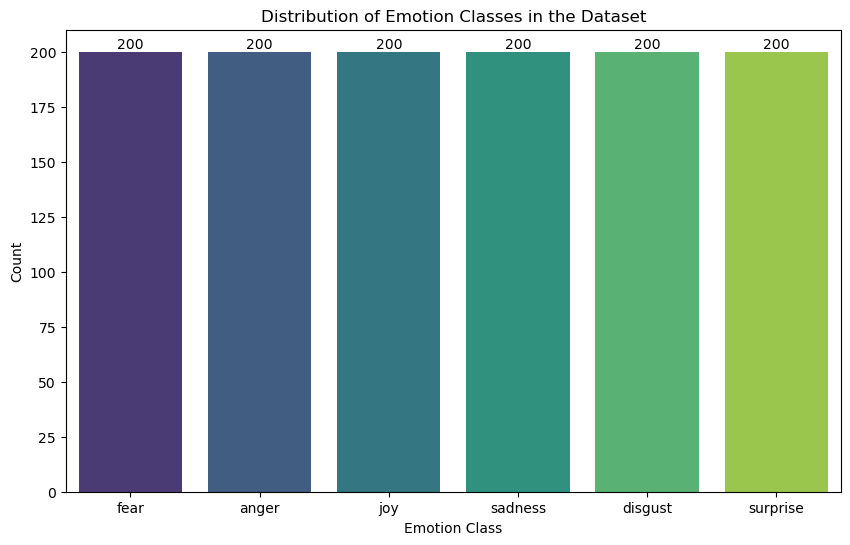

In [3]:
class_counts = dataset['emotion'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=dataset, order=class_counts.index, palette='viridis')

plt.title('Distribution of Emotion Classes in the Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Count')

plt.xticks(ticks=np.arange(len(class_counts)), labels=[class_names[i] for i in class_counts.index])

for i, count in enumerate(class_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

In [4]:
def data_preprocess(text, replace_patterns, word_to_stem):
    text = text.lower()

    for pattern, replacement in replace_patterns.items():
        text = pattern.sub(replacement, text)

    text = re.sub("[^a-zA-Z\s?!.]", '', text)
    tokens = word_tokenize(text)
    text = ' '.join([word_to_stem.get(word, word) for word in tokens])

    return text

dataset['text_preprocessed'] = dataset['text'].apply(data_preprocess, replace_patterns=replace_patterns, word_to_stem=word_to_stem)

display(dataset.head(10))

,text,emotion,text_preprocessed
0,Ako....Ako.... Ako talaga ang paborito niya.,1,ako .... ako .... ako talaga ang paborito niya .
1,Natatakot silang muling abutin ng bagyo.,1,takot silang muli abutin ng bagyo .
2,Takot ang lahat ng jeep at kotse sa kaniya.,1,takot ang lahat ng jeep at kotse sa kaniya .
3,Ang bilis-bilis ng takbo ni Kas kaya takot na ...,1,ang bilisbilis ng takbo ni kas kaya takot na t...
4,Ayan na! Ayan na si Kaskasero!,1,ayan na ! ayan na si kaskasero !
5,Unahan ang lahat sa pagtakbo para iwasan ang b...,1,unahan ang lahat sa pagtakbo para iwasan ang b...
6,"Pagbaba ng mga pasahero, nerbiyos na nerbiyos ...",1,pagbaba ng mga pasahero nerbiyos na nerbiyos s...
7,... dahil natatakot siya sa lahat.,1,... dahil takot siya sa lahat .
8,Takot siya sa mga eroplano . at tren,1,takot siya sa mga eroplano . at tren
9,Takot siya sa mga batang lalaki,1,takot siya sa mga bata lalaki


In [5]:
vectorizer = CountVectorizer()
sparse_matrix = vectorizer.fit_transform(dataset['text_preprocessed'])
sparse_matrix.todense()
CountVectorized = pd.DataFrame(sparse_matrix.toarray(), columns=vectorizer.get_feature_names_out())
CountVectorized_result = pd.concat([dataset['text_preprocessed'], CountVectorized], axis=1)

display(CountVectorized_result)

,text_preprocessed,aaliwin,ab,aba,abandoned,abaondonadong,abby,abiso,abril,abutin,...,yakapin,yaman,yari,yehey,yikes,you,yuck,yumukod,yung,zinnia
0,ako .... ako .... ako talaga ang paborito niya .,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,takot silang muli abutin ng bagyo .,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,takot ang lahat ng jeep at kotse sa kaniya .,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ang bilisbilis ng takbo ni kas kaya takot na t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ayan na ! ayan na si kaskasero !,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,grabe hindi ko talaga inaasahang magkakasama t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1196,nakakagulat talaga ang mga revelations sa pres...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1197,laki gulat ko nang bigla magiba ang itsura mo .,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1198,hindi ko inakala na darating ka ng ganito oras...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(sparse_matrix)
X_tfidf.todense()
tfidf = pd.DataFrame(X_tfidf.toarray(), columns = vectorizer.get_feature_names_out())
tfidf_result = pd.concat([dataset['text_preprocessed'], tfidf], axis=1)

display(tfidf_result)

,text_preprocessed,aaliwin,ab,aba,abandoned,abaondonadong,abby,abiso,abril,abutin,...,yakapin,yaman,yari,yehey,yikes,you,yuck,yumukod,yung,zinnia
0,ako .... ako .... ako talaga ang paborito niya .,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,takot silang muli abutin ng bagyo .,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,takot ang lahat ng jeep at kotse sa kaniya .,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ang bilisbilis ng takbo ni kas kaya takot na t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ayan na ! ayan na si kaskasero !,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,grabe hindi ko talaga inaasahang magkakasama t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1196,nakakagulat talaga ang mga revelations sa pres...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1197,laki gulat ko nang bigla magiba ang itsura mo .,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1198,hindi ko inakala na darating ka ng ganito oras...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
X = dataset['text_preprocessed']
Y = dataset['emotion']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", Y_train.shape)
print("y_test shape:", Y_test.shape)

X_train shape: (960,)
X_test shape: (240,)
y_train shape: (960,)
y_test shape: (240,)


In [8]:
train_class_counts = Y_train.value_counts()
print("Training Set Class Distribution:")
print(train_class_counts)

test_class_counts = Y_test.value_counts()
print("\nTesting Set Class Distribution:")
print(test_class_counts)


Training Set Class Distribution:
2    160
3    160
5    160
1    160
4    160
6    160
Name: emotion, dtype: int64

Testing Set Class Distribution:
1    40
5    40
6    40
3    40
2    40
4    40
Name: emotion, dtype: int64


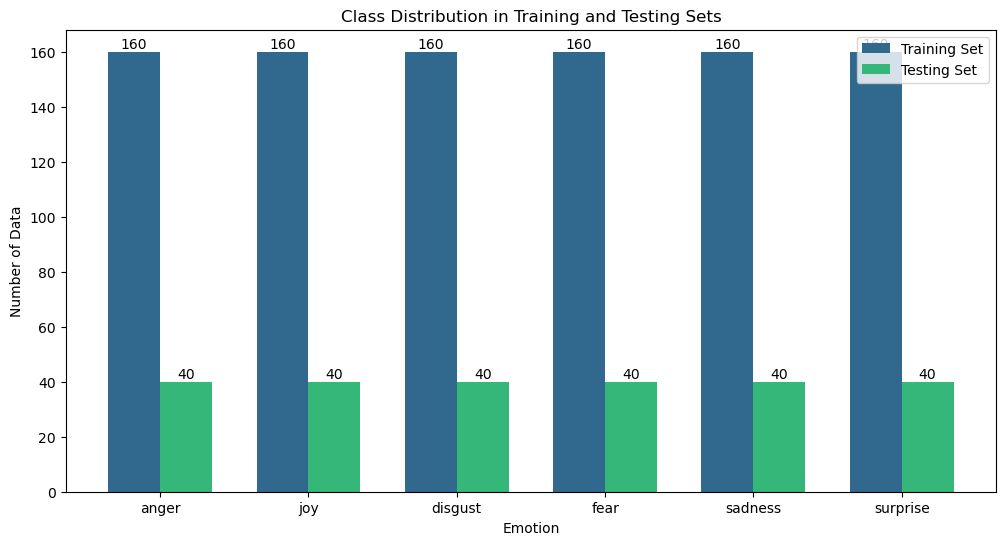

In [9]:
Y_train_names = Y_train.map(class_names)
Y_test_names = Y_test.map(class_names)

train_class_counts = Y_train_names.value_counts()
train_emotions = train_class_counts.index
train_counts = train_class_counts.values

test_class_counts = Y_test_names.value_counts()
test_emotions = test_class_counts.index
test_counts = test_class_counts.values

fig, ax = plt.subplots(figsize=(12, 6))
colors = sns.color_palette('viridis', n_colors=2)
bar_width = 0.35
bar_positions_train = np.arange(len(train_emotions))
bar_positions_test = bar_positions_train + bar_width

ax.bar(bar_positions_train, train_counts, bar_width, label='Training Set', color=colors[0])
ax.bar(bar_positions_test, test_counts, bar_width, label='Testing Set', color=colors[1])

ax.set_xlabel('Emotion')
ax.set_ylabel('Number of Data')
ax.set_title('Class Distribution in Training and Testing Sets')
ax.set_xticks(bar_positions_train + bar_width / 2)
ax.set_xticklabels(train_emotions)
ax.legend()

for i, count in enumerate(train_counts):
    ax.text(bar_positions_train[i], count, str(count), ha='center', va='bottom')
for i, count in enumerate(test_counts):
    ax.text(bar_positions_test[i], count, str(count), ha='center', va='bottom')

plt.show()

In [10]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("X_train_vectorized shape:", X_train_vectorized.shape)
print("X_test_vectorized shape:", X_test_vectorized.shape)

X_train_vectorized shape: (960, 1786)
X_test_vectorized shape: (240, 1786)


In [11]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vectorized)
X_test_tfidf = tfidf_transformer.transform(X_test_vectorized)

print("X_train_vectorized shape:", X_train_tfidf.shape)
print("X_test_vectorized shape:", X_test_tfidf.shape)

X_train_vectorized shape: (960, 1786)
X_test_vectorized shape: (240, 1786)


In [12]:
svm = SVC(kernel='poly', degree=3, gamma=0.01, coef0=2.0,C=1, random_state=42)
classifier = OneVsOneClassifier(svm)

cv_results = cross_validate(classifier, X_train_tfidf, Y_train, cv=5, scoring='accuracy', return_train_score=False)
classifier.fit(X_train_tfidf, Y_train)
Y_pred = classifier.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(Y_test, Y_pred))
print("\nCross-Validation Results:")
print("Mean Accuracy:", cv_results['test_score'].mean())
print("Individual Fold Accuracies:", cv_results['test_score'])

Accuracy: 0.7541666666666667

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.75      0.86        40
           2       0.96      0.68      0.79        40
           3       0.42      0.95      0.58        40
           4       0.85      0.72      0.78        40
           5       1.00      0.68      0.81        40
           6       0.97      0.75      0.85        40

    accuracy                           0.75       240
   macro avg       0.87      0.75      0.78       240
weighted avg       0.87      0.75      0.78       240


Cross-Validation Results:
Mean Accuracy: 0.6458333333333333
Individual Fold Accuracies: [0.61979167 0.671875   0.6875     0.609375   0.640625  ]


In [13]:
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__degree': [2, 3, 4],
    'estimator__gamma': [0.01, 0.1, 1],  
    'estimator__coef0': [0.0, 1.0, 2.0] 
}

grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, Y_train)
best_classifier = grid_search.best_estimator_
Y_pred = best_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

Best Parameters: {'estimator__C': 1, 'estimator__coef0': 1.0, 'estimator__degree': 3, 'estimator__gamma': 1}
Accuracy: 0.8541666666666666

Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.85      0.88        40
           2       0.88      0.88      0.88        40
           3       0.74      0.78      0.76        40
           4       0.72      0.85      0.78        40
           5       0.94      0.85      0.89        40
           6       0.97      0.93      0.95        40

    accuracy                           0.85       240
   macro avg       0.86      0.85      0.86       240
weighted avg       0.86      0.85      0.86       240



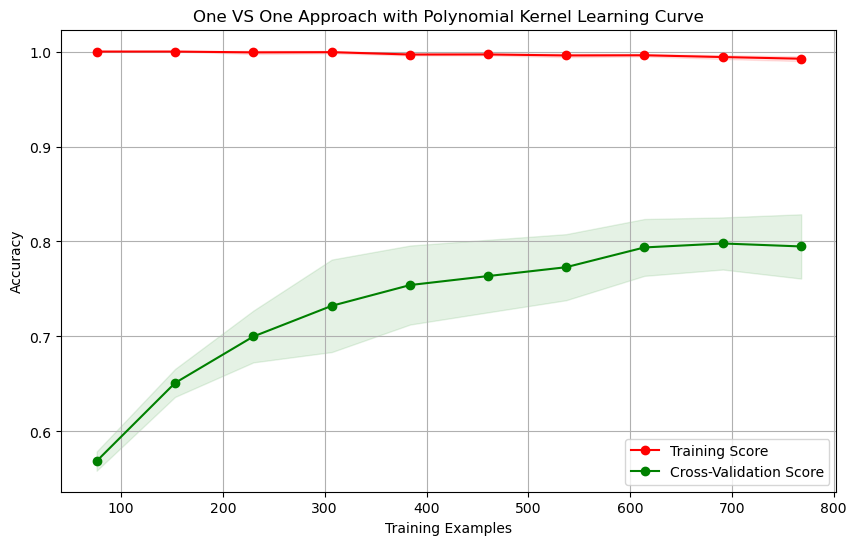

In [15]:
train_sizes, train_scores, test_scores = learning_curve(
    classifier, X_train_tfidf, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("One VS One Approach with Polynomial Kernel Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# K-Fold Cross-Validation loop
for fold, (train_index, test_index) in enumerate(skf.split(X, Y)):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    Y_train_fold, Y_test_fold = Y.iloc[train_index], Y.iloc[test_index]

    # Data preprocessing and vectorization for each fold
    X_train_vectorized_fold = vectorizer.fit_transform(X_train_fold)
    X_test_vectorized_fold = vectorizer.transform(X_test_fold)

    X_train_tfidf_fold = tfidf_transformer.fit_transform(X_train_vectorized_fold)
    X_test_tfidf_fold = tfidf_transformer.transform(X_test_vectorized_fold)

    svm = SVC(kernel='poly', degree=3, gamma=1, coef0=1.0,C=1, random_state=42)
    classifier_fold = OneVsOneClassifier(svm)

    # Fit the classifier on the training data for this fold
    classifier_fold.fit(X_train_tfidf_fold, Y_train_fold)

    # Predict the labels for the test set of this fold
    Y_pred_fold = classifier_fold.predict(X_test_tfidf_fold)

    # Evaluate performance metrics for this fold
    accuracy_scores.append(accuracy_score(Y_test_fold, Y_pred_fold))
    precision_scores.append(precision_score(Y_test_fold, Y_pred_fold, average='weighted'))
    recall_scores.append(recall_score(Y_test_fold, Y_pred_fold, average='weighted'))
    f1_scores.append(f1_score(Y_test_fold, Y_pred_fold, average='weighted'))

# Calculate and print average performance metrics across all folds
print(f'Average Accuracy: {np.mean(accuracy_scores)}')
print(f'Average Precision: {np.mean(precision_scores)}')
print(f'Average Recall: {np.mean(recall_scores)}')
print(f'Average F1 Score: {np.mean(f1_scores)}')


Average Accuracy: 0.825
Average Precision: 0.8394622297347581
Average Recall: 0.825
Average F1 Score: 0.8277353245566796
